In [55]:
import eikon as ek
import numpy as np
import pandas as pd
import json
import datetime as dt
import traceback
import math

# Import Cleaned Data

In [56]:
price_data = pd.read_csv("price_data_cleaned.csv")

In [57]:
price_data.describe()

,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,C3 - Close Price,C3 - Accumulated Volume,C4 - Close Price,C4 - Accumulated Volume,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return
count,166554.000000,166554.000000,166554.000000,166554.000000,166554.000000,1.664290e+05,166554.000000,1.665070e+05,162312.000000,1.622760e+05,162312.000000,1.622760e+05,166554.000000,166554.000000,162726.000000,162726.000000
mean,2007.503032,6.555964,15.772128,2.014272,2247.252814,1.925024e+05,2248.873235,1.765483e+05,2290.334560,4.550426e+04,2290.334560,4.550426e+04,0.000187,0.000119,0.000135,0.000135
std,8.644937,3.433873,8.750959,1.399904,10215.661480,3.268517e+06,10218.444864,2.920270e+06,10305.344406,1.103189e+06,10305.344406,1.103189e+06,0.016653,0.015798,0.014556,0.014556
min,1992.000000,1.000000,1.000000,0.000000,-13.100000,0.000000e+00,0.302000,0.000000e+00,0.308000,0.000000e+00,0.308000,0.000000e+00,-0.359333,-0.941776,-0.261407,-0.261407
25%,2000.000000,4.000000,8.000000,1.000000,19.490000,7.530000e+02,19.430000,2.519000e+03,19.800000,9.200000e+02,19.800000,9.200000e+02,-0.006027,-0.005932,-0.005422,-0.005422
50%,2008.000000,7.000000,16.000000,2.000000,111.450000,4.979000e+03,111.700000,1.022200e+04,112.850000,4.084000e+03,112.850000,4.084000e+03,0.000000,0.000000,0.000000,0.000000
75%,2015.000000,10.000000,23.000000,3.000000,502.750000,2.227400e+04,506.875000,3.527050e+04,524.000000,1.610625e+04,524.000000,1.610625e+04,0.006370,0.006090,0.005732,0.005732
max,2021.000000,12.000000,31.000000,6.000000,155880.000000,1.734515e+08,154750.000000,2.790027e+08,154540.000000,1.340868e+08,154540.000000,1.340868e+08,0.479290,0.387716,0.409346,0.409346


# Create Signals & Trading Data Set

In [58]:
price_data["C1 - C2 Carry"] = price_data["C2 - Close Price"] / price_data["Close Price"] - 1

In [59]:
price_data["Instrument - Lag"] = price_data.Instrument.shift(1)
price_data["Date - Lag"] = price_data.Date.shift(1)
price_data["C2 - Close Price - Lag"] = price_data["C2 - Close Price"].shift(1)
price_data["Close Price - Lag"] = price_data["Close Price"].shift(1)
price_data["C1 - C2 Carry - Lag"] = price_data["C1 - C2 Carry"].shift(1)

In [60]:
price_data["Date - Lag"] = price_data[["Instrument - Lag", "Instrument", "Date - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C2 - Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "C2 - Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["Close Price - Lag"] = price_data[["Instrument - Lag", "Instrument", "Close Price - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

price_data["C1 - C2 Carry - Lag"] = price_data[["Instrument - Lag", "Instrument", "C1 - C2 Carry - Lag"]].apply(
    lambda x: np.nan if x[0] != x[1] else x[2],
    axis=1
)

In [61]:
trading_data = price_data.copy()

In [62]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,Daily Adjusted Return,C2 - Daily Adjusted Return,C3 - Daily Adjusted Return,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag
0,SB,1992-01-03,1992,1,3,4,8.410,5154.0,8.370,3388.0,...,-0.020955,-0.018757,-0.012972,-0.012972,-0.004756,NaN,NaN,NaN,NaN,NaN
1,SB,1992-01-06,1992,1,6,0,8.500,4996.0,8.440,2751.0,...,0.010702,0.008363,0.003584,0.003584,-0.007059,SB,1992-01-03,8.370,8.410,-0.004756
2,SB,1992-01-07,1992,1,7,1,8.350,4846.0,8.320,4290.0,...,-0.017647,-0.014218,-0.007143,-0.007143,-0.003593,SB,1992-01-06,8.440,8.500,-0.007059
3,SB,1992-01-08,1992,1,8,2,8.430,5456.0,8.460,4665.0,...,0.009581,0.016827,0.014388,0.014388,0.003559,SB,1992-01-07,8.320,8.350,-0.003593
4,SB,1992-01-09,1992,1,9,3,8.450,4213.0,8.440,4566.0,...,0.002372,-0.002364,0.001182,0.001182,-0.001183,SB,1992-01-08,8.460,8.430,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,SI,2021-12-27,2021,12,27,0,22.680,1.0,23.060,108793.0,...,0.000000,0.000000,0.000000,0.000000,0.016755,SI,2021-12-23,22.895,22.835,0.002628
166550,SI,2021-12-28,2021,12,28,1,23.150,211.0,23.015,73451.0,...,0.000000,0.000000,0.000000,0.000000,-0.005832,SI,2021-12-27,23.060,22.680,0.016755
166551,SI,2021-12-29,2021,12,29,2,22.635,172.0,22.825,98976.0,...,0.000000,0.000000,0.000000,0.000000,0.008394,SI,2021-12-28,23.015,23.150,-0.005832
166552,SI,2021-12-30,2021,12,30,3,23.070,344.0,23.100,75359.0,...,0.000000,0.000000,0.000000,0.000000,0.001300,SI,2021-12-29,22.825,22.635,0.008394


In [63]:
trading_data.Date = pd.to_datetime(trading_data.Date)

Value Baseline

To calculate the value factor we need the average price over the past 5 years. The average excludes the current date to prevent forward-looking bias

In [64]:
trading_data.sort_values(["Instrument", "Date"], ascending=True, inplace=True)

trading_data["1Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "365d",
    on="Date",
    closed="neither"
)["Close Price"].mean().to_numpy()

trading_data["C2 - 1Y Average Price"] = trading_data.groupby(
    "Instrument"
).rolling(
    "365d",
    on="Date",
    closed="neither"
)["C2 - Close Price"].mean().to_numpy()

In [65]:
min_dates = trading_data.groupby("Instrument").agg(
    min_date = ("Date", "min")
).reset_index()

trading_data = trading_data.merge(min_dates, how="left")

trading_data["1Y Average Price"] = trading_data[[
    "1Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 365 else np.nan, axis=1
)
trading_data["C2 - 1Y Average Price"] = trading_data[[
    "C2 - 1Y Average Price",
    "Date",
    "min_date"
]].apply(
    lambda x: x[0] if (x[1] - x[2]) / np.timedelta64(1, 'D') > 365 else np.nan, axis=1
)

We trade on the first available trading day of every month

In [66]:
trading_data["Daily Adjusted Return"] += 1
trading_data["C2 - Daily Adjusted Return"] += 1
trading_data["C3 - Daily Adjusted Return"] += 1
trading_data["C4 - Daily Adjusted Return"] += 1

In [67]:
trading_data

,Instrument,Date,Year,Month,Day,Day of Week,Close Price,Accumulated Volume,C2 - Close Price,C2 - Accumulated Volume,...,C4 - Daily Adjusted Return,C1 - C2 Carry,Instrument - Lag,Date - Lag,C2 - Close Price - Lag,Close Price - Lag,C1 - C2 Carry - Lag,1Y Average Price,C2 - 1Y Average Price,min_date
0,C,1992-01-03,1992,1,3,4,248.75,23080.0,254.25,5508.0,...,0.993301,0.022111,KW,NaN,NaN,NaN,NaN,NaN,NaN,1992-01-03
1,C,1992-01-06,1992,1,6,0,250.00,20980.0,256.00,4266.0,...,1.005780,0.024000,C,1992-01-03,254.25,248.75,0.022111,NaN,NaN,1992-01-03
2,C,1992-01-07,1992,1,7,1,249.75,11869.0,256.00,4310.0,...,1.001916,0.025025,C,1992-01-06,256.00,250.00,0.024000,NaN,NaN,1992-01-03
3,C,1992-01-08,1992,1,8,2,253.00,18428.0,259.75,4042.0,...,1.009560,0.026680,C,1992-01-07,256.00,249.75,0.025025,NaN,NaN,1992-01-03
4,C,1992-01-09,1992,1,9,3,252.50,20440.0,259.25,6553.0,...,1.001894,0.026733,C,1992-01-08,259.75,253.00,0.026680,NaN,NaN,1992-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166549,W,2021-12-27,2021,12,27,0,805.75,52917.0,810.00,12813.0,...,0.994419,0.005275,W,2021-12-23,819.00,815.25,0.004600,699.814516,704.992944,1992-01-03
166550,W,2021-12-28,2021,12,28,1,784.00,64228.0,789.50,11353.0,...,0.977237,0.007015,W,2021-12-27,810.00,805.75,0.005275,700.584677,705.778226,1992-01-03
166551,W,2021-12-29,2021,12,29,2,789.25,78959.0,793.00,11679.0,...,1.003510,0.004751,W,2021-12-28,789.50,784.00,0.007015,701.248992,706.460685,1992-01-03
166552,W,2021-12-30,2021,12,30,3,780.50,74145.0,783.50,13878.0,...,0.985692,0.003844,W,2021-12-29,793.00,789.25,0.004751,701.852823,707.088710,1992-01-03


In [68]:
backtest_data = trading_data.sort_values(
    by="Date",
    ascending=True
).groupby([
    "Instrument", "Year", "Month"
]).agg(
    Day = ("Day", "first"),
    date = ("Date", "first"),
    close_price_lag = ("Close Price - Lag", "first"),
    c2_close_price_lag = ("C2 - Close Price - Lag", "first"),
    c1_c2_carry_signal = ("C1 - C2 Carry - Lag", "first"),
    adj_monthly_return = ("Daily Adjusted Return", "prod"),
    c2_adj_monthly_return = ("C2 - Daily Adjusted Return", "prod"),
    adj_monthly_var = ("Daily Adjusted Return", np.std),
    c2_adj_monthly_var = ("C2 - Daily Adjusted Return", np.std),
    y1_mean_price = ("1Y Average Price", "first"),
    c2_y1_mean_price = ("C2 - 1Y Average Price", "first")
).reset_index()

In [69]:
backtest_data["momentum_signal"] = (backtest_data.groupby("Instrument").adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").adj_monthly_var.shift(1)

backtest_data["value_signal"] = np.log(backtest_data.groupby("Instrument")["y1_mean_price"].shift(4*12+6) / backtest_data["close_price_lag"])

backtest_data["c2_momentum_signal"] = (backtest_data.groupby("Instrument").c2_adj_monthly_return.shift(1) - 1) / backtest_data.groupby("Instrument").c2_adj_monthly_var.shift(1)

backtest_data["c2_value_signal"] = np.log(backtest_data.groupby("Instrument")["c2_y1_mean_price"].shift(4*12+6) / backtest_data["c2_close_price_lag"])

# We only drop NA values for carry & signal now as dropping value would incur a hefty loss in the amount of data
backtest_data.dropna(
    subset=[
        "c1_c2_carry_signal",
        "momentum_signal",
        "c2_momentum_signal"
    ],
    inplace=True
)

In [70]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011


Basis-Momentum Signal

In [71]:
backtest_data["c1_c2_basis_momentum_signal"]  = backtest_data.close_price_lag / backtest_data.groupby("Instrument").close_price_lag.shift(12) \
    - backtest_data.c2_close_price_lag / backtest_data.groupby("Instrument").c2_close_price_lag.shift(12)

In [72]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal
1,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN,NaN
2,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN,NaN
3,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN,NaN
4,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN,NaN
5,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8391,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513
8392,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206
8393,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588
8394,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226


# Add Risk-Free Rate

In [73]:
# Read in data
# Retrieved from https://www.multpl.com/1-year-treasury-rate/table/by-month
risk_free_rate = pd.read_csv("us_1yt.csv")
# Transform to a monthly basis
risk_free_rate["risk_free_rate"] = risk_free_rate["risk_free_rate"].apply(lambda x: (1+x)**(1/12) - 1)

In [74]:
backtest_data = backtest_data.merge(risk_free_rate, how="left")

In [75]:
backtest_data

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,adj_monthly_var,c2_adj_monthly_var,y1_mean_price,c2_y1_mean_price,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate
0,C,1992,2,3,1992-02-03,264.00,270.25,0.023674,1.002841,1.013876,0.010022,0.011309,NaN,NaN,7.210539,NaN,7.237623,NaN,NaN,0.003507
1,C,1992,3,2,1992-03-02,264.75,274.00,0.034939,1.020887,1.004501,0.007213,0.007605,NaN,NaN,0.283455,NaN,1.226960,NaN,NaN,0.003779
2,C,1992,4,1,1992-04-01,264.00,269.25,0.019886,0.923295,0.927577,0.008083,0.008303,NaN,NaN,2.895649,NaN,0.591895,NaN,NaN,0.003515
3,C,1992,5,1,1992-05-01,243.75,249.75,0.024615,1.054299,1.052023,0.012753,0.011620,NaN,NaN,-9.489053,NaN,-8.722805,NaN,NaN,0.003426
4,C,1992,6,1,1992-06-01,259.50,264.00,0.017341,0.957611,0.959280,0.013771,0.014253,NaN,NaN,4.257707,NaN,4.476899,NaN,NaN,0.003410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,0.017681,0.017467,626.326613,629.095766,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,0.012899,0.012722,644.916331,648.138105,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,0.014990,0.014640,657.928427,661.548387,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,0.018993,0.018696,669.581653,674.126008,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150


# Build Strategies
For all strategies we assume that 70% of the cash is invested at the risk-free rate while the remaining 30% is used for margin

In [107]:
# This parameter (ranging from 0-80%) decides how much cash is invested at the risk-free rate
cash_pct = 0.7

## Carry Strategies

In [76]:
# Rank the carries for each month so we can get the top & bottom percentiles
backtest_data["Carry Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_carry_signal"].rank("average", ascending=True,pct=True )

Positive Carry Test

In [80]:
positive_carry_test = backtest_data[
    backtest_data["Carry Rank"] >= 2/3
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [81]:
positive_carry_test["x"] = positive_carry_test["Year"] + (positive_carry_test["Month"] - 1) / 12

In [82]:
positive_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.970561,0.003507
1,1992.166667,1.008021,0.003779
2,1992.250000,0.977645,0.003515
3,1992.333333,1.007000,0.003426
4,1992.416667,0.994948,0.003410
...,...,...,...
354,2021.583333,1.045636,0.000058
355,2021.666667,0.974312,0.000067
356,2021.750000,1.026724,0.000092
357,2021.833333,1.009064,0.000150


In [83]:
# Add the risk-free rate and calculate cumulative returns
positive_carry_test["y_tot"] = (2 - positive_carry_test["y"]) + cash_pct * positive_carry_test["rf"]
positive_carry_test["y_cum"] = positive_carry_test["y_tot"].cumprod()

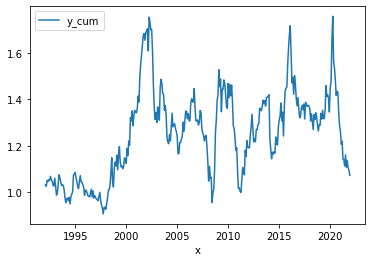

In [85]:
positive_carry_test.plot.line(x="x", y="y_cum")

In [87]:
positive_carry_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.000934
std,0.038470
min,0.867066
25%,0.978102
50%,0.998503
75%,1.024761
max,1.146315


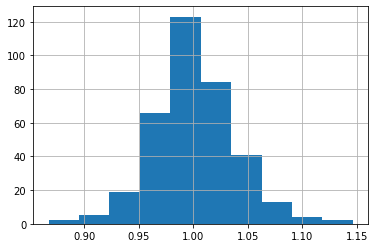

In [88]:
positive_carry_test["y_tot"].hist()

Negative Carry Test

In [89]:
negative_carry_test = backtest_data[
    (backtest_data["Carry Rank"] <= 1/3)
].groupby(["Year", "Month"]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [90]:
negative_carry_test["x"] = negative_carry_test["Year"] + (negative_carry_test["Month"] - 1) / 12

In [91]:
negative_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.999899,0.003507
1,1992.166667,0.992977,0.003779
2,1992.250000,0.986872,0.003515
3,1992.333333,1.044906,0.003426
4,1992.416667,1.010671,0.003410
...,...,...,...
354,2021.583333,0.980413,0.000058
355,2021.666667,1.041894,0.000067
356,2021.750000,1.005262,0.000092
357,2021.833333,0.955206,0.000150


In [92]:
# Add the risk-free rate and calculate cumulative returns
negative_carry_test["y_tot"] = negative_carry_test["y"] + cash_pct * negative_carry_test["rf"]
negative_carry_test["y_cum"] = negative_carry_test["y_tot"].cumprod()

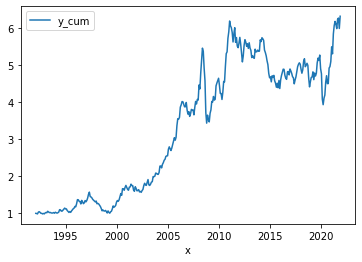

In [93]:
negative_carry_test.plot.line(x="x", y="y_cum")

In [94]:
negative_carry_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.005894
std,0.038602
min,0.811096
25%,0.980539
50%,1.002354
75%,1.029387
max,1.120550


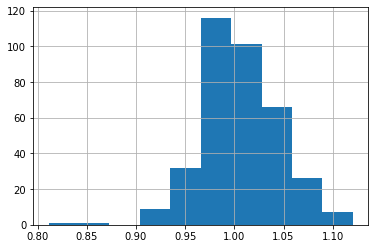

In [95]:
negative_carry_test["y_tot"].hist()

Combined Carry Test

In [96]:
# Combine the short & long leg together
combined_carry_test = positive_carry_test[["x", "y_tot"]].merge(negative_carry_test[["x", "y_tot"]], on="x")

In [98]:
# We invest 50/50 between the short and long leg
combined_carry_test["y"] = (combined_carry_test["y_tot_x"] + combined_carry_test["y_tot_y"]) / 2

In [99]:
combined_carry_test[["x", "y"]]

,x,y_tot
0,1992.083333,1.017124
1,1992.166667,0.995123
2,1992.250000,1.007074
3,1992.333333,1.021351
4,1992.416667,1.010248
...,...,...
354,2021.583333,0.967429
355,2021.666667,1.033838
356,2021.750000,0.989334
357,2021.833333,0.973176


In [100]:
combined_carry_test["y_cum"] = combined_carry_test["y"].cumprod()

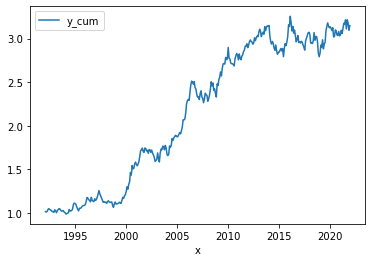

In [101]:
combined_carry_test.plot.line(x="x", y="y_cum")

In [102]:
combined_carry_test[["y"]].describe()

,y_tot
count,359.000000
mean,1.003414
std,0.020817
min,0.954016
25%,0.989626
50%,1.002632
75%,1.015160
max,1.078505


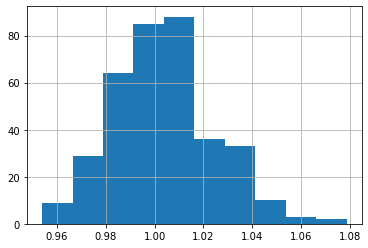

In [103]:
combined_carry_test["y"].hist()

Equal Weighted Long Commodity Test

In [104]:
ew_commodity_test = backtest_data.groupby([
    "Year", "Month"
]).agg(y = ("c2_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [105]:
ew_commodity_test["x"] = ew_commodity_test["Year"] + (ew_commodity_test["Month"] - 1) / 12

In [106]:
ew_commodity_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.987582,0.003507
1,1992.166667,1.002805,0.003779
2,1992.250000,0.995651,0.003515
3,1992.333333,1.024674,0.003426
4,1992.416667,1.006917,0.003410
...,...,...,...
354,2021.583333,1.005498,0.000058
355,2021.666667,1.007544,0.000067
356,2021.750000,1.011736,0.000092
357,2021.833333,0.993376,0.000150


In [109]:
ew_commodity_test["y_tot"] = ew_commodity_test["y"] + cash_pct * ew_commodity_test["rf"]
ew_commodity_test["y_cum"] = ew_commodity_test["y_tot"].cumprod()

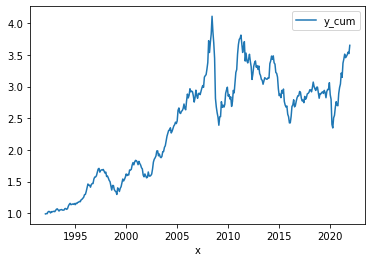

In [110]:
ew_commodity_test.plot.line(x="x", y="y_cum")

In [111]:
ew_commodity_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.004114
std,0.031427
min,0.816382
25%,0.984998
50%,1.005579
75%,1.021112
max,1.101357


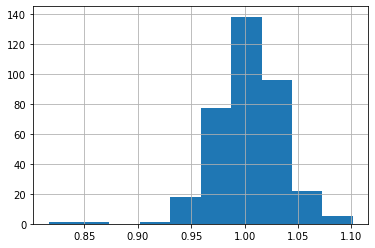

In [112]:
ew_commodity_test["y_tot"].hist()

## Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [115]:
backtest_data["c1_c2_momentum_signal"] = (backtest_data["momentum_signal"] + backtest_data["c2_momentum_signal"]) / 2
backtest_data["Momentum Rank"] = backtest_data.groupby(["Year", "Month"])["c1_c2_momentum_signal"].rank("average", ascending=True,pct=True)

In [116]:
backtest_data[backtest_data["Momentum Rank"] >= 2/3].c2_adj_monthly_return.product() - 1

89.11968908419607

In [117]:
backtest_data[backtest_data["Momentum Rank"] <= 1/3].c2_adj_monthly_return.product() - 1

-0.998828980491889

Positive Momentum Test

In [118]:
positive_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] >= 2/3
].groupby(
    ["Year", "Month"]
).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [119]:
positive_momentum_test["x"] = positive_momentum_test["Year"] + (positive_momentum_test["Month"] - 1) / 12

In [120]:
positive_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.981155,0.003507
1,1992.166667,1.032154,0.003779
2,1992.250000,1.061608,0.003515
3,1992.333333,1.063997,0.003426
4,1992.416667,1.002342,0.003410
...,...,...,...
354,2021.583333,1.017667,0.000058
355,2021.666667,0.995150,0.000067
356,2021.750000,1.004274,0.000092
357,2021.833333,0.985823,0.000150


In [121]:
positive_momentum_test["y_tot"] = positive_momentum_test["y"] + cash_pct * positive_momentum_test["rf"]
positive_momentum_test["y_cum"] = positive_momentum_test["y_tot"].cumprod()

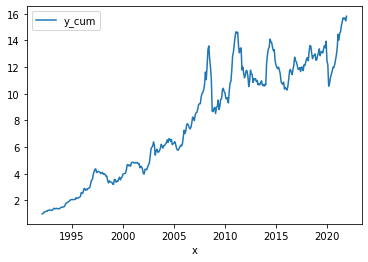

In [122]:
positive_momentum_test.plot.line(x="x", y="y_cum")

In [123]:
positive_momentum_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.008574
std,0.041276
min,0.787401
25%,0.987311
50%,1.009451
75%,1.028374
max,1.152269


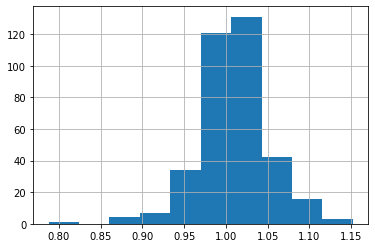

In [124]:
positive_momentum_test["y_tot"].hist()

Negative Momentum Test

In [125]:
negative_momentum_test = backtest_data[
    backtest_data["Momentum Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [126]:
negative_momentum_test["x"] = negative_momentum_test["Year"] + (negative_momentum_test["Month"] - 1) / 12

In [127]:
negative_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.986055,0.003507
1,1992.166667,1.002746,0.003779
2,1992.250000,0.982796,0.003515
3,1992.333333,0.997278,0.003426
4,1992.416667,1.043439,0.003410
...,...,...,...
354,2021.583333,1.008900,0.000058
355,2021.666667,0.994908,0.000067
356,2021.750000,1.018235,0.000092
357,2021.833333,0.971956,0.000150


In [128]:
negative_momentum_test["y_tot"] = (2 - negative_momentum_test["y"]) + cash_pct * negative_momentum_test["rf"]
negative_momentum_test["y_cum"] = (2 - negative_momentum_test["y_tot"]).cumprod()

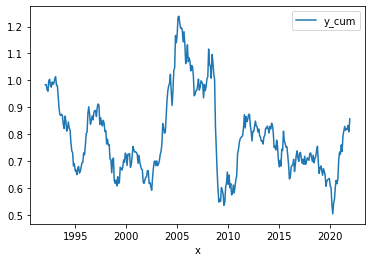

In [129]:
negative_momentum_test.plot.line(x="x", y="y_cum")

In [130]:
negative_momentum_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,0.999549
std,0.041974
min,0.874081
25%,0.975171
50%,0.997953
75%,1.024694
max,1.173926


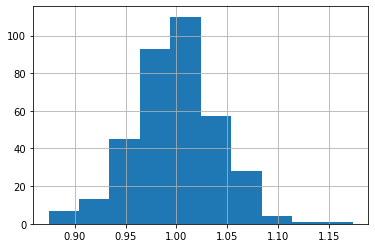

In [131]:
negative_momentum_test["y_tot"].hist()

Combined Momentum Test

In [132]:
combined_momentum_test = negative_momentum_test[["x", "y_tot"]].merge(positive_momentum_test[["x", "y_tot"]], on="x")

In [133]:
combined_momentum_test["y"] = (combined_momentum_test["y_tot_x"] + combined_momentum_test["y_tot_y"]) / 2

In [134]:
combined_momentum_test[["x", "y"]]

,x,y_tot
0,1992.083333,1.000005
1,1992.166667,1.017349
2,1992.250000,1.041866
3,1992.333333,1.035758
4,1992.416667,0.981839
...,...,...
354,2021.583333,1.004424
355,2021.666667,1.000168
356,2021.750000,0.993083
357,2021.833333,1.007039


In [135]:
combined_momentum_test["y_cum"] = combined_momentum_test["y"].cumprod()

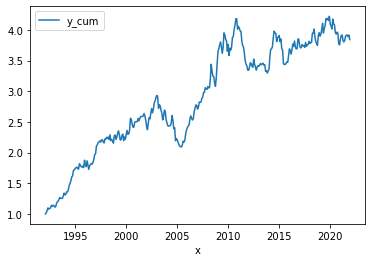

In [136]:
combined_momentum_test.plot.line(x="x", y="y_cum")

In [137]:
combined_momentum_test[["y"]].describe()

,y_tot
count,359.000000
mean,1.004061
std,0.024765
min,0.912188
25%,0.989591
50%,1.002839
75%,1.018749
max,1.082458


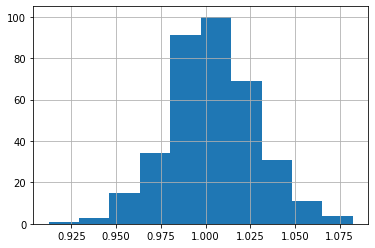

In [138]:
combined_momentum_test["y"].hist()

## Carry-Momentum V3
Rather than optimizing carry with momentum, we optimize momentum with carry

Negative Momentum-Carry Test

In [139]:
negative_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] <= 1/3)
].copy()
negative_momentum_carry_v3_test["pick_adj_monthly_return"] = negative_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [140]:
negative_momentum_carry_v3_test["x"] = negative_momentum_carry_v3_test["Year"] + (negative_momentum_carry_v3_test["Month"] - 1) / 12

In [141]:
negative_momentum_carry_v3_test = negative_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
negative_momentum_carry_v3_test.fillna(1, inplace=True)
negative_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [142]:
negative_momentum_carry_v3_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,0.973007,0.003507
1,1992.166667,1.001992,0.003779
2,1992.250000,0.982722,0.003515
3,1992.333333,0.996871,0.003426
4,1992.416667,1.031182,0.003410
...,...,...,...
354,2021.583333,1.008222,0.000058
355,2021.666667,0.995705,0.000067
356,2021.750000,1.014796,0.000092
357,2021.833333,0.975646,0.000150


In [145]:
negative_momentum_carry_v3_test["y_tot"] = (2 - negative_momentum_carry_v3_test["y"]) + cash_pct * negative_momentum_carry_v3_test["rf"]
negative_momentum_carry_v3_test["y_cum"] = negative_momentum_carry_v3_test["y_tot"].cumprod()

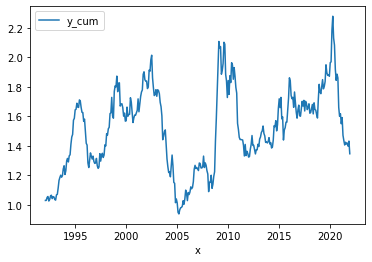

In [146]:
negative_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [147]:
negative_momentum_carry_v3_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.001656
std,0.040737
min,0.883060
25%,0.976190
50%,1.002548
75%,1.025182
max,1.170635


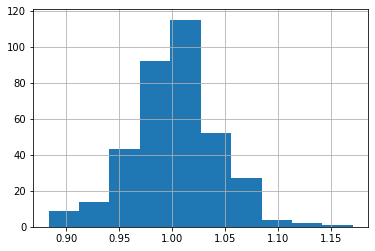

In [148]:
negative_momentum_carry_v3_test["y_tot"].hist()

Positive Momentum-Carry Test

In [149]:
positive_momentum_carry_v3_test = backtest_data[
    (backtest_data["Momentum Rank"] >= 2/3)
].copy()
positive_momentum_carry_v3_test["pick_adj_monthly_return"] = positive_momentum_carry_v3_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [150]:
positive_momentum_carry_v3_test["x"] = positive_momentum_carry_v3_test["Year"] + (positive_momentum_carry_v3_test["Month"] - 1) / 12

In [151]:
positive_momentum_carry_v3_test = positive_momentum_carry_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
positive_momentum_carry_v3_test.fillna(1, inplace=True)
positive_momentum_carry_v3_test.sort_values(by="x", inplace=True)

In [152]:
positive_momentum_carry_v3_test[["x", "y", "rf"]]

,x,y,rf
0,1992.083333,1.015966,0.003507
1,1992.166667,1.032154,0.003779
2,1992.250000,1.045401,0.003515
3,1992.333333,1.049480,0.003426
4,1992.416667,1.000193,0.003410
...,...,...,...
354,2021.583333,1.014124,0.000058
355,2021.666667,0.996984,0.000067
356,2021.750000,0.998075,0.000092
357,2021.833333,0.986423,0.000150


In [153]:
positive_momentum_carry_v3_test["y_tot"] = positive_momentum_carry_v3_test["y"] + cash_pct * positive_momentum_carry_v3_test["rf"]
positive_momentum_carry_v3_test["y_cum"] = positive_momentum_carry_v3_test["y_tot"].cumprod()

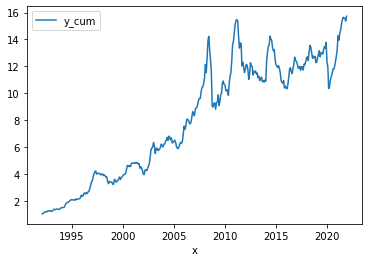

In [154]:
positive_momentum_carry_v3_test.plot.line(x="x", y="y_cum")

In [155]:
positive_momentum_carry_v3_test[["y_tot"]].describe()

,y_tot
count,359.000000
mean,1.008525
std,0.040340
min,0.782980
25%,0.987379
50%,1.009597
75%,1.029325
max,1.134742


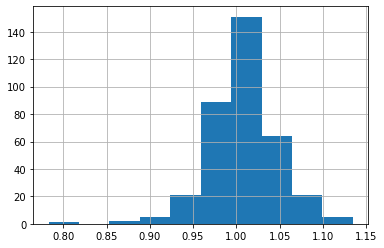

In [156]:
positive_momentum_carry_v3_test["y_tot"].hist()

Combined Carry Momentum Test

In [157]:
combined_carry_momentum_v3_test = negative_momentum_carry_v3_test[["x", "y_tot"]].merge(positive_momentum_carry_v3_test[["x", "y_tot"]], on="x", how="outer")

In [158]:
combined_carry_momentum_v3_test = combined_carry_momentum_v3_test.merge(ew_commodity_test[["x"]], on="x", how="outer")
combined_carry_momentum_v3_test.fillna(1, inplace=True)
combined_carry_momentum_v3_test.sort_values(by="x", inplace=True)

In [163]:
combined_carry_momentum_v3_test["y"] = (combined_carry_momentum_v3_test["y_tot_x"] + combined_carry_momentum_v3_test["y_tot_y"]) / 2

In [164]:
combined_carry_momentum_v3_test[["x", "y"]]

,x,y
0,1992.083333,1.023934
1,1992.166667,1.017726
2,1992.250000,1.033800
3,1992.333333,1.028703
4,1992.416667,0.986893
...,...,...
354,2021.583333,1.002992
355,2021.666667,1.000687
356,2021.750000,0.991703
357,2021.833333,1.005493


In [165]:
combined_carry_momentum_v3_test["y_cum"] = combined_carry_momentum_v3_test["y"].cumprod()

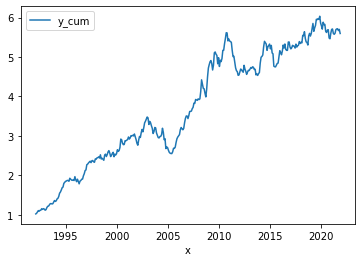

In [166]:
combined_carry_momentum_v3_test.plot.line(x="x", y="y_cum")

In [167]:
combined_carry_momentum_v3_test[["y"]].describe()

,y
count,359.000000
mean,1.005090
std,0.023815
min,0.914199
25%,0.990756
50%,1.004610
75%,1.018825
max,1.077589


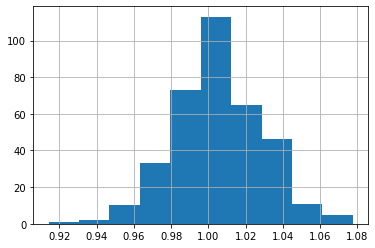

In [168]:
combined_carry_momentum_v3_test["y"].hist()

## Basis-Momentum Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [169]:
backtest_data_basis_momentum = backtest_data[~pd.isnull(backtest_data.c1_c2_basis_momentum_signal)].copy()

In [170]:
backtest_data_basis_momentum

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
12,C,1993,2,1,1993-02-01,214.50,222.25,0.036131,0.983683,0.986502,...,-1.634837,NaN,-1.320033,NaN,-0.009887,0.002782,0.947368,9,-1.477435,0.263158
13,C,1993,3,1,1993-03-01,211.00,219.25,0.039100,1.080047,1.069305,...,-3.966922,NaN,-4.005884,NaN,-0.003204,0.002734,0.900000,9,-3.986403,0.200000
14,C,1993,4,1,1993-04-01,230.00,235.50,0.023913,0.993478,0.988323,...,11.072632,NaN,6.609377,NaN,-0.003440,0.002661,0.800000,8,8.841005,1.000000
15,C,1993,5,3,1993-05-03,228.50,232.75,0.018600,0.994679,0.987121,...,-0.714555,NaN,-1.227507,NaN,0.005504,0.002758,0.900000,9,-0.971031,0.500000
16,C,1993,6,1,1993-06-01,224.50,229.50,0.022272,0.992205,0.997821,...,-0.551086,NaN,-1.441430,NaN,-0.004193,0.002903,0.850000,8,-0.996258,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,7,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,8,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,8,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,8,4.420591,0.740741


In [171]:
backtest_data_basis_momentum["Basis-Momentum Rank"] = backtest_data_basis_momentum.groupby(["Year", "Month"])["c1_c2_basis_momentum_signal"].rank("average", ascending=True,pct=True)

In [172]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3].adj_monthly_return.product() - 1

267918.1459640176

In [173]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] <= 2/3].adj_monthly_return.product() - 1

-0.994664257876897

Positive Momentum Test

In [174]:
positive_basis_momentum_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [175]:
positive_basis_momentum_test["x"] = positive_basis_momentum_test["Year"] + (positive_basis_momentum_test["Month"] - 1) / 12

In [176]:
positive_basis_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.028002,0.002782
1,1993.166667,0.999112,0.002734
2,1993.250000,1.045604,0.002661
3,1993.333333,0.941280,0.002758
4,1993.416667,0.987620,0.002903
...,...,...,...
342,2021.583333,1.001686,0.000058
343,2021.666667,1.038310,0.000067
344,2021.750000,1.027688,0.000092
345,2021.833333,0.971770,0.000150


In [177]:
positive_basis_momentum_test["y_tot"] = positive_basis_momentum_test["y"] + cash_pct * positive_basis_momentum_test["rf"]
positive_basis_momentum_test["y_cum"] = positive_basis_momentum_test["y_tot"].cumprod()

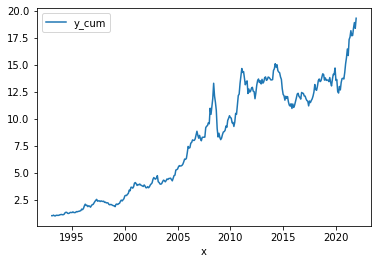

In [178]:
positive_basis_momentum_test.plot.line(x="x", y="y_cum")

In [179]:
positive_basis_momentum_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.009371
std,0.040383
min,0.843634
25%,0.983632
50%,1.006602
75%,1.034008
max,1.150452


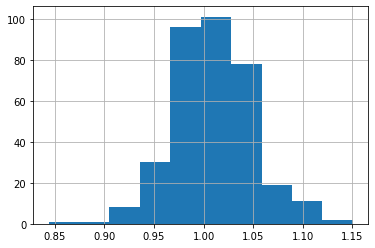

In [180]:
positive_basis_momentum_test["y_tot"].hist()

Negative Momentum Test

In [183]:
negative_basis_momentum_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [184]:
negative_basis_momentum_test["x"] = negative_basis_momentum_test["Year"] + (negative_basis_momentum_test["Month"] - 1) / 12

In [185]:
negative_basis_momentum_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.036301,0.002782
1,1993.166667,1.029843,0.002734
2,1993.250000,0.986971,0.002661
3,1993.333333,0.965458,0.002758
4,1993.416667,0.951654,0.002903
...,...,...,...
342,2021.583333,1.026253,0.000058
343,2021.666667,0.988420,0.000067
344,2021.750000,0.982835,0.000092
345,2021.833333,0.993945,0.000150


In [186]:
negative_basis_momentum_test["y_tot"] = (2 - negative_basis_momentum_test["y"]) + cash_pct * negative_basis_momentum_test["rf"]
negative_basis_momentum_test["y_cum"] = negative_basis_momentum_test["y_tot"].cumprod()

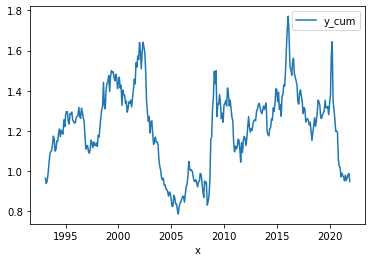

In [187]:
negative_basis_momentum_test.plot.line(x="x", y="y_cum")

In [188]:
negative_basis_momentum_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.000669
std,0.040559
min,0.821302
25%,0.977648
50%,0.998960
75%,1.024300
max,1.207202


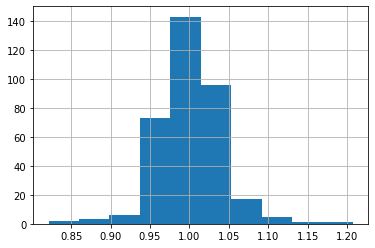

In [189]:
negative_basis_momentum_test["y_tot"].hist()

Combined Momentum Test

In [190]:
combined_basis_momentum_test = negative_basis_momentum_test[["x", "y_tot"]].merge(positive_basis_momentum_test[["x", "y_tot"]], on="x")

In [191]:
combined_basis_momentum_test["y"] = (combined_basis_momentum_test["y_tot_x"] + combined_basis_momentum_test["y_tot_y"]) / 2

In [192]:
combined_basis_momentum_test[["x", "y"]]

,x,y
0,1993.083333,0.997798
1,1993.166667,0.986548
2,1993.250000,1.031179
3,1993.333333,0.989841
4,1993.416667,1.020015
...,...,...
342,2021.583333,0.987757
343,2021.666667,1.024992
344,2021.750000,1.022491
345,2021.833333,0.989017


In [193]:
combined_basis_momentum_test["y_cum"] = combined_basis_momentum_test["y"].cumprod()

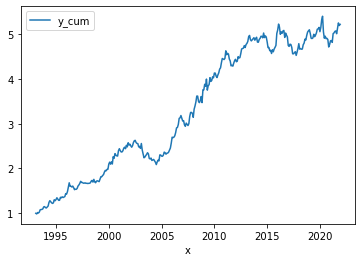

In [194]:
combined_basis_momentum_test.plot.line(x="x", y="y_cum")

In [195]:
combined_basis_momentum_test[["y"]].describe()

,y
count,347.000000
mean,1.005020
std,0.022245
min,0.935317
25%,0.990630
50%,1.004125
75%,1.017785
max,1.082676


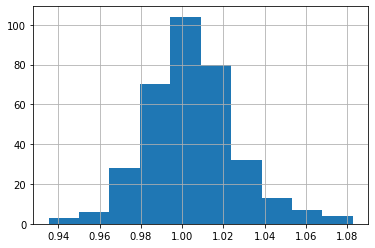

In [196]:
combined_basis_momentum_test["y"].hist()

## Basis-Momentum-Carry Test

Rank the momentum for each month so we can get the top & bottom percentiles

In [197]:
backtest_data_basis_momentum = backtest_data[~pd.isnull(backtest_data.c1_c2_basis_momentum_signal)].copy()

In [198]:
backtest_data_basis_momentum

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
12,C,1993,2,1,1993-02-01,214.50,222.25,0.036131,0.983683,0.986502,...,-1.634837,NaN,-1.320033,NaN,-0.009887,0.002782,0.947368,9,-1.477435,0.263158
13,C,1993,3,1,1993-03-01,211.00,219.25,0.039100,1.080047,1.069305,...,-3.966922,NaN,-4.005884,NaN,-0.003204,0.002734,0.900000,9,-3.986403,0.200000
14,C,1993,4,1,1993-04-01,230.00,235.50,0.023913,0.993478,0.988323,...,11.072632,NaN,6.609377,NaN,-0.003440,0.002661,0.800000,8,8.841005,1.000000
15,C,1993,5,3,1993-05-03,228.50,232.75,0.018600,0.994679,0.987121,...,-0.714555,NaN,-1.227507,NaN,0.005504,0.002758,0.900000,9,-0.971031,0.500000
16,C,1993,6,1,1993-06-01,224.50,229.50,0.022272,0.992205,0.997821,...,-0.551086,NaN,-1.441430,NaN,-0.004193,0.002903,0.850000,8,-0.996258,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,7,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,8,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,8,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,8,4.420591,0.740741


In [199]:
backtest_data_basis_momentum["Basis-Momentum Rank"] = backtest_data_basis_momentum.groupby(["Year", "Month"])["c1_c2_basis_momentum_signal"].rank("average", ascending=True,pct=True)

In [200]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3].adj_monthly_return.product() - 1

267918.1459640176

In [201]:
backtest_data_basis_momentum[backtest_data_basis_momentum["Basis-Momentum Rank"] <= 2/3].adj_monthly_return.product() - 1

-0.994664257876897

Positive Momentum Test

In [202]:
positive_basis_momentum_carry_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] >= 2/3
].copy()
positive_basis_momentum_carry_test["pick_adj_monthly_return"] = positive_basis_momentum_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_basis_momentum_carry_test = positive_basis_momentum_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [203]:
positive_basis_momentum_carry_test["x"] = positive_basis_momentum_carry_test["Year"] + (positive_basis_momentum_carry_test["Month"] - 1) / 12

In [204]:
positive_basis_momentum_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.011024,0.002782
1,1993.166667,1.005288,0.002734
2,1993.250000,1.034902,0.002661
3,1993.333333,0.980971,0.002758
4,1993.416667,0.997139,0.002903
...,...,...,...
342,2021.583333,0.991638,0.000058
343,2021.666667,1.042367,0.000067
344,2021.750000,1.026057,0.000092
345,2021.833333,0.975745,0.000150


In [205]:
positive_basis_momentum_carry_test["y_tot"] = positive_basis_momentum_carry_test["y"] + cash_pct * positive_basis_momentum_carry_test["rf"]
positive_basis_momentum_carry_test["y_cum"] = positive_basis_momentum_carry_test["y_tot"].cumprod()

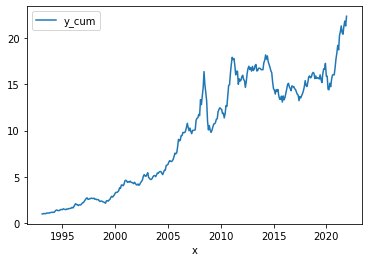

In [206]:
positive_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [207]:
positive_basis_momentum_carry_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.009738
std,0.038836
min,0.836206
25%,0.984455
50%,1.007048
75%,1.033997
max,1.148019


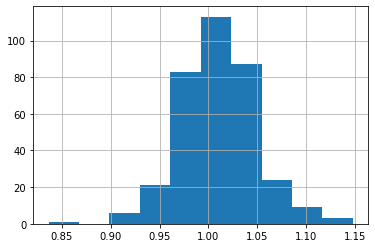

In [208]:
positive_basis_momentum_carry_test["y_tot"].hist()

Negative Momentum Test

In [209]:
negative_basis_momentum_carry_test = backtest_data_basis_momentum[
    backtest_data_basis_momentum["Basis-Momentum Rank"] <= 1/3
].copy()
negative_basis_momentum_carry_test["pick_adj_monthly_return"] = negative_basis_momentum_carry_test[[
    "adj_monthly_return",
   "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_basis_momentum_carry_test = negative_basis_momentum_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [210]:
negative_basis_momentum_carry_test["x"] = negative_basis_momentum_carry_test["Year"] + (negative_basis_momentum_carry_test["Month"] - 1) / 12

In [211]:
negative_basis_momentum_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1993.083333,1.031277,0.002782
1,1993.166667,1.027638,0.002734
2,1993.250000,0.986280,0.002661
3,1993.333333,0.969054,0.002758
4,1993.416667,0.952148,0.002903
...,...,...,...
342,2021.583333,1.023969,0.000058
343,2021.666667,0.984118,0.000067
344,2021.750000,0.978441,0.000092
345,2021.833333,0.996796,0.000150


In [212]:
negative_basis_momentum_carry_test["y_tot"] = (2 - negative_basis_momentum_carry_test["y"]) + cash_pct * negative_basis_momentum_carry_test["rf"]
negative_basis_momentum_carry_test["y_cum"] = negative_basis_momentum_carry_test["y_tot"].cumprod()

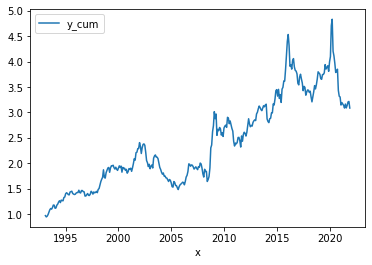

In [213]:
negative_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [214]:
negative_basis_momentum_carry_test[["y_tot"]].describe()

,y_tot
count,347.000000
mean,1.003989
std,0.038598
min,0.858676
25%,0.980287
50%,1.003748
75%,1.025456
max,1.206567


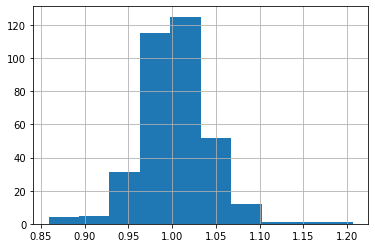

In [215]:
negative_basis_momentum_carry_test["y_tot"].hist()

Combined Momentum Test

In [216]:
combined_basis_momentum_carry_test = negative_basis_momentum_carry_test[["x", "y_tot"]].merge(positive_basis_momentum_carry_test[["x", "y_tot"]], on="x")

In [217]:
combined_basis_momentum_carry_test["y"] = (combined_basis_momentum_carry_test["y_tot_x"] + combined_basis_momentum_carry_test["y_tot_y"]) / 2

In [218]:
combined_basis_momentum_carry_test[["x", "y"]]

,x,y
0,1993.083333,0.991821
1,1993.166667,0.990739
2,1993.250000,1.026173
3,1993.333333,1.007889
4,1993.416667,1.024527
...,...,...
342,2021.583333,0.983875
343,2021.666667,1.029171
344,2021.750000,1.023872
345,2021.833333,0.989580


In [219]:
combined_basis_momentum_carry_test["y_cum"] = combined_basis_momentum_carry_test["y"].cumprod()

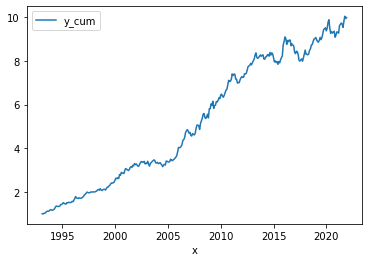

In [220]:
combined_basis_momentum_carry_test.plot.line(x="x", y="y_cum")

In [222]:
combined_basis_momentum_carry_test[["y"]].describe()

,y
count,347.000000
mean,1.006864
std,0.020490
min,0.945957
25%,0.992736
50%,1.006212
75%,1.019135
max,1.077995


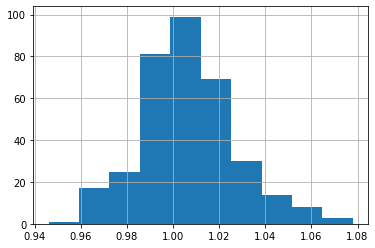

In [223]:
combined_basis_momentum_carry_test["y"].hist()

## Value Test

Rank the value for each month so we can get the top & bottom percentiles

In [224]:
backtest_data_value = backtest_data[~pd.isnull(backtest_data.value_signal)].copy()

In [225]:
backtest_data_value

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
65,C,1997,7,1,1997-07-01,248.50,238.00,-0.042254,0.997047,1.063998,...,-7.035649,-0.043005,-6.689042,0.022085,-0.115842,0.004503,0.166667,1,-6.862345,0.277778
66,C,1997,8,1,1997-08-01,265.00,267.00,0.007547,1.001887,1.006554,...,-0.115449,-0.121166,3.624374,-0.106021,-0.084729,0.004519,0.684211,6,1.754463,0.578947
67,C,1997,9,2,1997-09-02,265.50,268.75,0.012241,0.995707,1.006667,...,0.084522,-0.140012,0.304606,-0.128946,-0.065617,0.004488,0.736842,7,0.194564,0.473684
68,C,1997,10,1,1997-10-01,257.50,266.50,0.034951,1.086408,1.085366,...,-0.234639,-0.128345,0.574452,-0.139032,-0.008202,0.004440,0.900000,9,0.169907,0.600000
69,C,1997,11,3,1997-11-03,279.75,289.25,0.033959,0.969616,0.970614,...,5.247790,-0.219570,5.431540,-0.228927,-0.008770,0.004440,0.900000,9,5.339665,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,7,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,8,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,8,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,8,4.420591,0.740741


In [226]:
backtest_data_value["c1_c2_value_signal"] = (backtest_data_value["value_signal"] + backtest_data_value["c2_value_signal"]) / 2
backtest_data_value["Value Rank"] = backtest_data_value.groupby(["Year", "Month"])["c1_c2_value_signal"].rank("average", ascending=True,pct=True)

In [227]:
backtest_data_value[backtest_data_value["Value Rank"] >= 2/3].adj_monthly_return.product() - 1

834.1664201782403

In [228]:
backtest_data_value[backtest_data_value["Value Rank"] <= 1/3].adj_monthly_return.product() - 1

-0.8573351429105511

Positive Value Test

In [229]:
positive_value_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [230]:
positive_value_test["x"] = positive_value_test["Year"] + (positive_value_test["Month"] - 1) / 12

In [231]:
positive_value_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,1.053600,0.004503
1,1997.583333,0.966751,0.004519
2,1997.666667,1.027404,0.004488
3,1997.750000,0.972897,0.004440
4,1997.833333,0.959697,0.004440
...,...,...,...
289,2021.583333,1.040431,0.000058
290,2021.666667,0.984052,0.000067
291,2021.750000,0.996471,0.000092
292,2021.833333,0.982720,0.000150


In [233]:
positive_value_test["y_tot"] = positive_value_test["y"] + cash_pct * positive_value_test["rf"]
positive_value_test["y_cum"] = positive_value_test["y_tot"].cumprod()

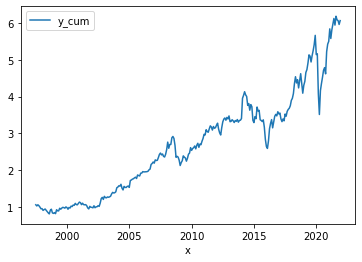

In [234]:
positive_value_test.plot.line(x="x", y="y_cum")

In [235]:
positive_value_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,1.007159
std,0.044918
min,0.789539
25%,0.982841
50%,1.009383
75%,1.032815
max,1.184924


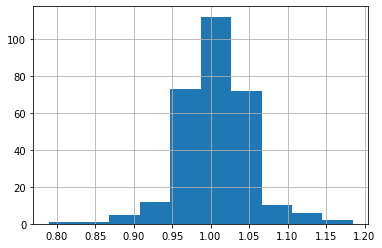

In [236]:
positive_value_test["y_tot"].hist()

Negative Value Test

In [237]:
negative_value_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].groupby([
    "Year", "Month"
]).agg(y = ("adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [238]:
negative_value_test["x"] = negative_value_test["Year"] + (negative_value_test["Month"] - 1) / 12

In [239]:
negative_value_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,0.994577,0.004503
1,1997.583333,0.990811,0.004519
2,1997.666667,0.968856,0.004488
3,1997.750000,0.991536,0.004440
4,1997.833333,0.990388,0.004440
...,...,...,...
289,2021.583333,1.001915,0.000058
290,2021.666667,1.011672,0.000067
291,2021.750000,1.009841,0.000092
292,2021.833333,0.979838,0.000150


In [240]:
negative_value_test["y_tot"] = (2 - negative_value_test["y"]) + cash_pct * negative_value_test["rf"]
negative_value_test["y_cum"] = negative_value_test["y_tot"].cumprod()

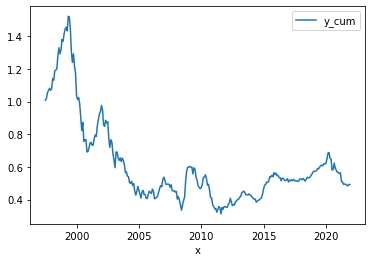

In [241]:
negative_value_test.plot.line(x="x", y="y_cum")

In [242]:
negative_value_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,0.998681
std,0.046982
min,0.866185
25%,0.976094
50%,1.001713
75%,1.021486
max,1.238450


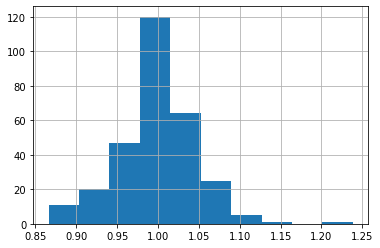

In [243]:
negative_value_test["y_tot"].hist()

Combined Value Test

In [244]:
combined_value = negative_value_test[["x", "y_tot"]].merge(positive_value_test[["x", "y_tot"]], on="x")

In [245]:
combined_value["y"] = (combined_value["y_tot_x"] + combined_value["y_tot_y"]) / 2

In [246]:
combined_value[["x", "y"]]

,x,y
0,1997.500000,1.032664
1,1997.583333,0.991133
2,1997.666667,1.032416
3,1997.750000,0.993789
4,1997.833333,0.987763
...,...,...
289,2021.583333,1.019299
290,2021.666667,0.986237
291,2021.750000,0.993379
292,2021.833333,1.001546


In [247]:
combined_value["y_cum"] = combined_value["y"].cumprod()

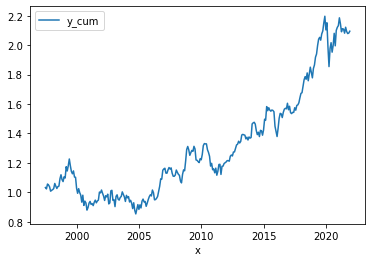

In [248]:
combined_value.plot.line(x="x", y="y_cum")

In [249]:
combined_value[["y"]].describe()

,y
count,294.000000
mean,1.002920
std,0.028365
min,0.923297
25%,0.983955
50%,1.003905
75%,1.021567
max,1.088237


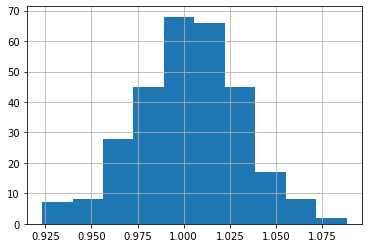

In [250]:
combined_value["y"].hist()

## Value-Carry

Rank the value for each month so we can get the top & bottom percentiles

In [251]:
backtest_data_value = backtest_data[~pd.isnull(backtest_data.value_signal)].copy()

In [252]:
backtest_data_value

,Instrument,Year,Month,Day,date,close_price_lag,c2_close_price_lag,c1_c2_carry_signal,adj_monthly_return,c2_adj_monthly_return,...,momentum_signal,value_signal,c2_momentum_signal,c2_value_signal,c1_c2_basis_momentum_signal,risk_free_rate,Carry Rank,Carry Rank Group,c1_c2_momentum_signal,Momentum Rank
65,C,1997,7,1,1997-07-01,248.50,238.00,-0.042254,0.997047,1.063998,...,-7.035649,-0.043005,-6.689042,0.022085,-0.115842,0.004503,0.166667,1,-6.862345,0.277778
66,C,1997,8,1,1997-08-01,265.00,267.00,0.007547,1.001887,1.006554,...,-0.115449,-0.121166,3.624374,-0.106021,-0.084729,0.004519,0.684211,6,1.754463,0.578947
67,C,1997,9,2,1997-09-02,265.50,268.75,0.012241,0.995707,1.006667,...,0.084522,-0.140012,0.304606,-0.128946,-0.065617,0.004488,0.736842,7,0.194564,0.473684
68,C,1997,10,1,1997-10-01,257.50,266.50,0.034951,1.086408,1.085366,...,-0.234639,-0.128345,0.574452,-0.139032,-0.008202,0.004440,0.900000,9,0.169907,0.600000
69,C,1997,11,3,1997-11-03,279.75,289.25,0.033959,0.969616,0.970614,...,5.247790,-0.219570,5.431540,-0.228927,-0.008770,0.004440,0.900000,9,5.339665,0.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142,W,2021,8,2,2021-08-02,703.50,712.75,0.013149,1.004620,1.015784,...,-5.260120,-0.487450,-5.226479,-0.467118,0.002513,0.000058,0.703704,7,-5.243299,0.111111
8143,W,2021,9,1,2021-09-01,706.75,724.00,0.024407,0.977518,0.975809,...,0.261281,-0.495544,0.903645,-0.484742,-0.014206,0.000067,0.851852,8,0.582463,0.555556
8144,W,2021,10,1,2021-10-01,725.75,736.50,0.014812,1.065105,1.065852,...,-1.742975,-0.529955,-1.901552,-0.507432,-0.006588,0.000092,0.851852,8,-1.822264,0.481481
8145,W,2021,11,1,2021-11-01,773.00,785.00,0.015524,1.004528,1.005732,...,4.343118,-0.602484,4.498064,-0.579011,-0.016226,0.000150,0.851852,8,4.420591,0.740741


In [253]:
backtest_data_value["c1_c2_value_signal"] = (backtest_data_value["value_signal"] + backtest_data_value["c2_value_signal"]) / 2
backtest_data_value["Value Rank"] = backtest_data_value.groupby(["Year", "Month"])["c1_c2_value_signal"].rank("average", ascending=True,pct=True)

In [254]:
backtest_data_value[backtest_data_value["Value Rank"] >= 2/3].adj_monthly_return.product() - 1

834.1664201782403

In [255]:
backtest_data_value[backtest_data_value["Value Rank"] <= 1/3].adj_monthly_return.product() - 1

-0.8573351429105511

Positive Value Test

In [256]:
positive_value_carry_test = backtest_data_value[
    backtest_data_value["Value Rank"] >= 2/3
].copy()
positive_value_carry_test["pick_adj_monthly_return"] = positive_value_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] >= 0 else x[1],
    axis=1
)
positive_value_carry_test = positive_value_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [257]:
positive_value_carry_test["x"] = positive_value_carry_test["Year"] + (positive_value_carry_test["Month"] - 1) / 12

In [258]:
positive_value_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,1.053600,0.004503
1,1997.583333,0.967950,0.004519
2,1997.666667,1.027404,0.004488
3,1997.750000,0.978417,0.004440
4,1997.833333,0.961172,0.004440
...,...,...,...
289,2021.583333,1.038966,0.000058
290,2021.666667,0.986451,0.000067
291,2021.750000,0.998585,0.000092
292,2021.833333,0.985207,0.000150


In [260]:
positive_value_carry_test["y_tot"] = positive_value_carry_test["y"] + cash_pct * positive_value_carry_test["rf"]
positive_value_carry_test["y_cum"] = positive_value_carry_test["y_tot"].cumprod()

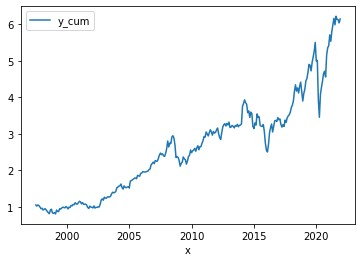

In [261]:
positive_value_carry_test.plot.line(x="x", y="y_cum")

In [262]:
positive_value_carry_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,1.007180
std,0.044418
min,0.786574
25%,0.981912
50%,1.009184
75%,1.033115
max,1.180489


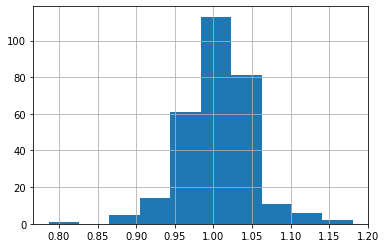

In [263]:
positive_value_carry_test["y_tot"].hist()

Negative Value Test

In [264]:
negative_value_carry_test = backtest_data_value[
    backtest_data_value["Value Rank"] <= 1/3
].copy()
negative_value_carry_test["pick_adj_monthly_return"] = negative_value_carry_test[[
    "adj_monthly_return",
    "c2_adj_monthly_return",
    "c1_c2_carry_signal"
]].apply(
    lambda x: x[0] if x[2] <= 0 else x[1],
    axis=1
)
negative_value_carry_test = negative_value_carry_test.groupby([
    "Year", "Month"
]).agg(y = ("pick_adj_monthly_return", "mean"), rf = ("risk_free_rate", "mean")).reset_index()

In [265]:
negative_value_carry_test["x"] = negative_value_carry_test["Year"] + (negative_value_carry_test["Month"] - 1) / 12

In [266]:
negative_value_carry_test[["x", "y", "rf"]]

,x,y,rf
0,1997.500000,0.991423,0.004503
1,1997.583333,0.980594,0.004519
2,1997.666667,0.971705,0.004488
3,1997.750000,0.993540,0.004440
4,1997.833333,0.991145,0.004440
...,...,...,...
289,2021.583333,1.003085,0.000058
290,2021.666667,1.012708,0.000067
291,2021.750000,1.010720,0.000092
292,2021.833333,0.979394,0.000150


In [267]:
negative_value_carry_test["y_tot"] = (2 - negative_value_carry_test["y"]) + cash_pct * negative_value_carry_test["rf"]
negative_value_carry_test["y_cum"] = (2 - negative_value_carry_test["y_tot"]).cumprod()

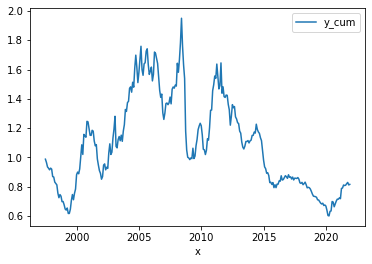

In [268]:
negative_value_carry_test.plot.line(x="x", y="y_cum")

In [269]:
negative_value_carry_test[["y_tot"]].describe()

,y_tot
count,294.000000
mean,0.999587
std,0.046804
min,0.865976
25%,0.975907
50%,1.002947
75%,1.024320
max,1.233605


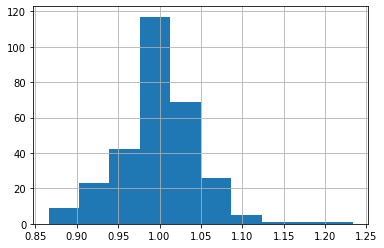

In [270]:
negative_value_carry_test["y_tot"].hist()

Combined Value Test

In [271]:
combined_value_carry_test = negative_value_carry_test[["x", "y_tot"]].merge(positive_value_carry_test[["x", "y_tot"]], on="x")

In [276]:
combined_value_carry_test["y"] = (combined_value_carry_test["y_tot_x"] + combined_value_carry_test["y_tot_y"]) / 2

In [277]:
combined_value_carry_test[["x", "y"]]

,x,y
0,1997.500000,1.034241
1,1997.583333,0.996841
2,1997.666667,1.030991
3,1997.750000,0.995546
4,1997.833333,0.988121
...,...,...
289,2021.583333,1.017981
290,2021.666667,0.986918
291,2021.750000,0.993997
292,2021.833333,1.003011


In [278]:
combined_value_carry_test["y_cum"] = combined_value_carry_test["y"].cumprod()

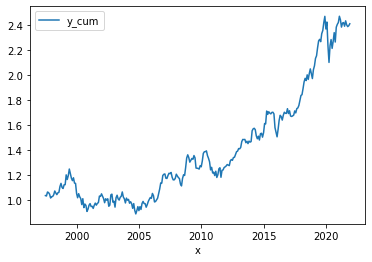

In [279]:
combined_value_carry_test.plot.line(x="x", y="y_cum")

In [280]:
combined_value_carry_test[["y"]].describe()

,y
count,294.000000
mean,1.003383
std,0.027699
min,0.921360
25%,0.985185
50%,1.004159
75%,1.021163
max,1.086001


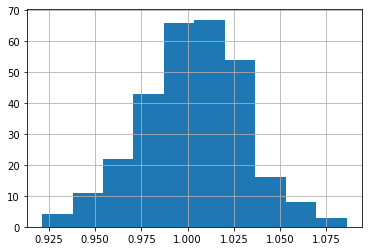

In [281]:
combined_value_carry_test["y"].hist()

# Output Plots

In [282]:
combined_carry_test.to_csv("combined_carry_test.csv", index=False)
ew_commodity_test.to_csv("ew_test.csv", index=False)
combined_momentum_test.to_csv("combined_momentum_test.csv", index=False)
combined_carry_momentum_v3_test.to_csv("combined_carry_momentum_v3_test.csv", index=False)
combined_basis_momentum_test.to_csv("combined_basis_momentum_test.csv", index=False)
combined_basis_momentum_carry_test.to_csv("combined_basis_momentum_carry_test.csv", index=False)
combined_value.to_csv("combined_value_test.csv", index=False)
combined_value_carry_test.to_csv("combined_value_carry_test.csv", index=False)

In [283]:
import matplotlib.pyplot as plt
import numpy as np

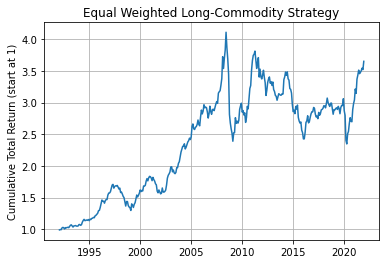

In [284]:
fig, ax = plt.subplots()
ax.plot(ew_commodity_test["x"], ew_commodity_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Equal Weighted Long-Commodity Strategy')

ax.grid()

fig.savefig("ew_long_commodity_cum_return.png")
plt.show()

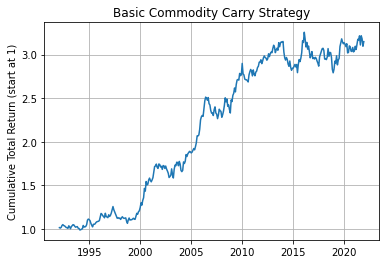

In [285]:
fig, ax = plt.subplots()
ax.plot(combined_carry_test["x"], combined_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Basic Commodity Carry Strategy')

ax.grid()

fig.savefig("basic_carry_cum_return.png")
plt.show()

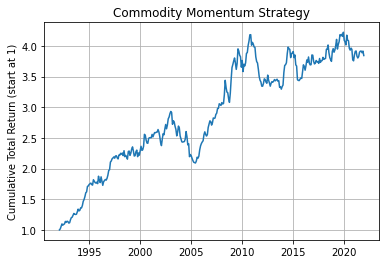

In [286]:
fig, ax = plt.subplots()
ax.plot(combined_momentum_test["x"], combined_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum Strategy')

ax.grid()

fig.savefig("basic_momentum_cum_return.png")
plt.show()

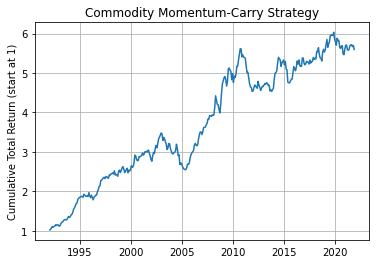

In [287]:
fig, ax = plt.subplots()
ax.plot(combined_carry_momentum_v3_test["x"], combined_carry_momentum_v3_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Momentum-Carry Strategy')

ax.grid()

fig.savefig("momentum_carry_cum_return.png")
plt.show()

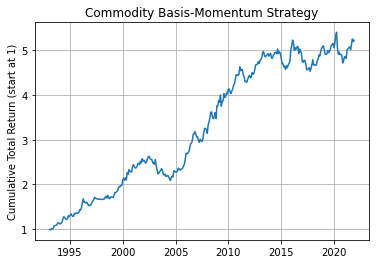

In [288]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_test["x"], combined_basis_momentum_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum Strategy')

ax.grid()

fig.savefig("basis_momentum_cum_return.png")
plt.show()

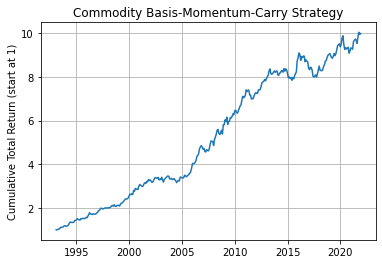

In [289]:
fig, ax = plt.subplots()
ax.plot(combined_basis_momentum_carry_test["x"], combined_basis_momentum_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Basis-Momentum-Carry Strategy')

ax.grid()

fig.savefig("basis_momentum_carry_cum_return.png")
plt.show()

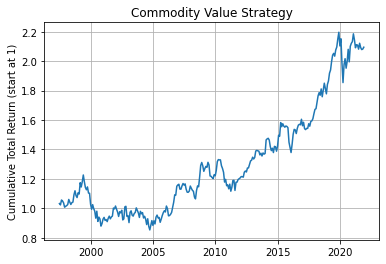

In [290]:
fig, ax = plt.subplots()
ax.plot(combined_value["x"], combined_value["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value Strategy')

ax.grid()

fig.savefig("value_cum_return.png")
plt.show()

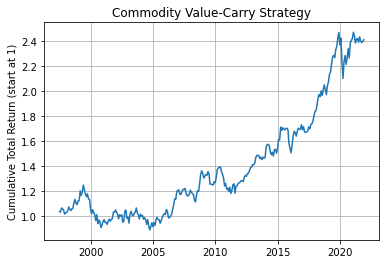

In [292]:
fig, ax = plt.subplots()
ax.plot(combined_value_carry_test["x"], combined_value_carry_test["y_cum"])

ax.set(xlabel='', ylabel='Cumulative Total Return (start at 1)',
       title='Commodity Value-Carry Strategy')

ax.grid()

fig.savefig("value_carry_cum_return.png")
plt.show()